# Assignment 6

## About

This week is all about Quantum Phase Estimation and Shor's Algorithm. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate
from math import gcd, lcm
from fractions import Fraction

Let's start by focusing on Quantum Phase Estimation. We will try to use QPE with the T-gate and the eigenstate $\ket{1}$ to derive the corresponding eigenvalue. 
##### 1. Implement a function T(n), which returns the matrix representation of $T^{(2^n)}$.

In [2]:
def T(n):
    t_gate = np.array([[1, 0],[0, np.exp((1j*np.pi)/4)]])
    return np.pow(t_gate, np.pow(2,n))

In [3]:
print(T(2))

[[ 1.+0.0000000e+00j  0.+0.0000000e+00j]
 [ 0.+0.0000000e+00j -1.+4.4408921e-16j]]


To perform Quantum Phase Estimation, we will also need a gate which implements the inverse Quantum Fourier Transform. If you completed Assignment 5, you may reuse your implementation. Otherwise, a function which returns an inverse QFT as a gate on $n$ qubits is provided below.

In [4]:
def k_to_lambda(k):
    return np.pi/(2**(k-1))

def QFT_inverse(n):
    qc = QuantumCircuit(n)
    for i in range(n//2-1, -1, -1):
        j = n-i-1
        qc.swap(i, j)
    for i in range(n):
        for j in range(i):
            k = i-j+1
            qc.cp(-k_to_lambda(k), j, i)
        qc.h(i)
    
    gate = qc.to_gate(label="$QFT^\dagger$")
    return gate

Finally, we need to be able to add any arbitrary (controlled) unitary gate to our quantum circuit. The basic approach to do this is shown below.

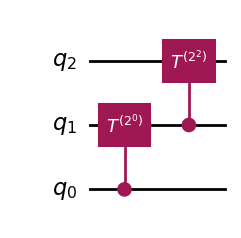

In [5]:
def Tn_to_controlled_gate(n):
    gate = UnitaryGate(T(n), label=f"$T^{{(2^{n})}}$")
    # make it a controlled version
    gate = gate.control()
    return gate

# Example circuit with two controlled T^2^n gates:
qc = QuantumCircuit(3)
T0 = Tn_to_controlled_gate(0)
qc.append(T0, [0, 1])
T2 = Tn_to_controlled_gate(2)
qc.append(T2, [1, 2])
qc.draw("mpl", reverse_bits=True)

##### 2. Implement the function QPE(num_control_qubits), which implements the circuit to perform Quantum Phase Estimation on the T gate with eigenstate $\ket{1}$ and with varying number of control-qubits (As we can see from the lecture notes, this must be a minimum of 3 to get the necessary precision).

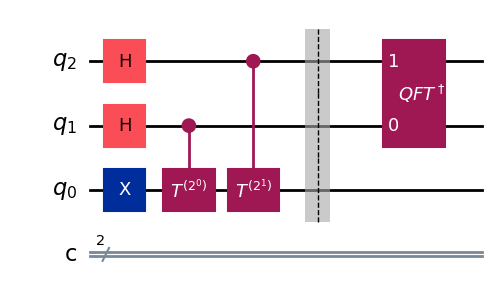

In [6]:
def QPE(num_control_qubits: int = 3) -> QuantumCircuit:
    total_qubits = 1 + num_control_qubits
    qc = QuantumCircuit(total_qubits, num_control_qubits)

    qc.x(0)
    for i in range(1, num_control_qubits+1):
        qc.h(i)
    for i in range(num_control_qubits):
        qc.append(Tn_to_controlled_gate(i), [i+1, 0])

    qc.barrier()

    qc.append(QFT_inverse(num_control_qubits), range(1, num_control_qubits+1))
    return qc

qc = QPE(num_control_qubits=2)
qc.draw("mpl", reverse_bits=True)

##### 3. Perform 1000 measurement shots of your circuit and plot the result as a histogram. How can you infer the corresponding eigenvalue based on these measurement results? What happens if we increase the precision beyond the minimum requirement (3)? What if we go below?

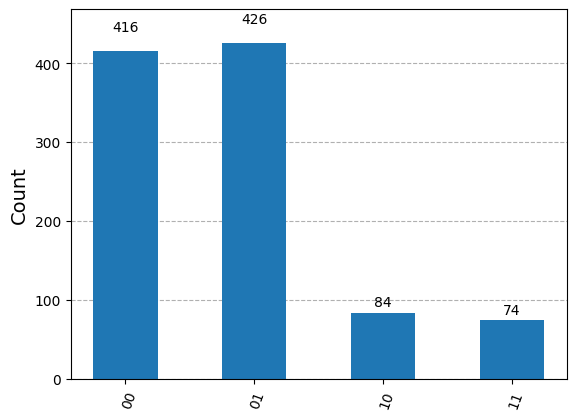

In [7]:
backend = AerSimulator()

n_bits = 2
qc.measure(range(1, n_bits+1), range(n_bits))
t_qc = transpile(qc, backend) # To save you some time debugging, you will likely need to transpile your QuantumCircuit in order to run it.
job = backend.run(t_qc, shots=1000)
result = job.result()
plot_histogram(result.get_counts())

---
### Shor's Algorithm

A function on the form $f(x)=a^x \bmod{N}$ is periodic (so long as $a<N$ and $a$ and $N$ are co-prime). This means that there exists some value $r$ (which we call the period) such that $f(x)=f(x+r)$. 

Thanks to number theory, we can deduce that finding the value of $r$ gives us a high chance of finding non-trivial factors of $N$. This in turn allows us to break a lot of modern cryptography, which are based on the assumption that there exists no polynomial time algorithm for integer factorization.

In this assignment, we will focus on how this could be done in practise, while glossing over some of the number theory that makes it all possible. 

Below is a function which plots the values of $a^x \bmod{N}$ for different values of $a$ and $N$, along with the detected period $r$. Play around a bit with different values of $a$ and $N$ and reason with yourself why certain values work / do not work. 

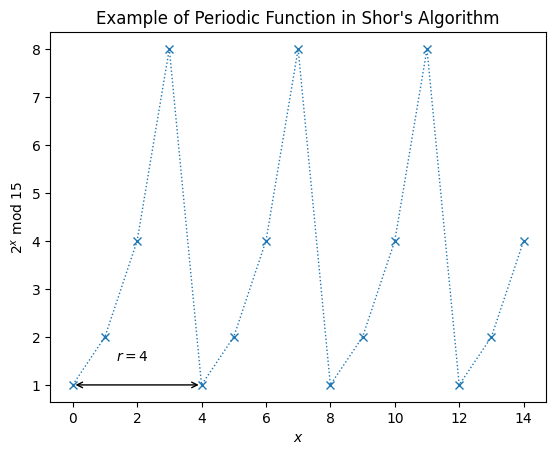

In [8]:
def period_plot(a, N):
    xvals = np.arange(N)
    yvals = [pow(a, int(x), N) for x in xvals]

    _, ax = plt.subplots()
    ax.plot(xvals, yvals, linewidth=1, linestyle="dotted", marker="x")
    ax.set(
        xlabel="$x$",
        ylabel=f"${a}^x$ mod ${N}$",
        title="Example of Periodic Function in Shor's Algorithm",
    )
    try:
        r = yvals[1:].index(1) + 1
        plt.annotate("", xy=(0, 1), xytext=(r, 1), arrowprops=dict(arrowstyle="<->"))
        plt.annotate(f"$r={r}$", xy=(r / 3, 1.5))
    except ValueError:
        print("Could not find period, check a < N and have no common factors.")


period_plot(2, 15)

Let's try to factorize the number $N=15$.

To perform Shor's Algorithm we need a gate such that $U^x \ket{1} = \ket{a^x \bmod{N}}$. Constructing the controlled version of such a gate is not trivial, so we will instead use some code provided by qiskit. The below function does just that, for arbitrary choices of $a$ and the power $x$.

In [9]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2, 4, 7, 8, 11, 13, 14]:
        raise ValueError("'a' must be 2, 4, 7, 8, 11, 13 or 14")
    U = QuantumCircuit(4)
    for _ in range(power):
        if a in [2, 13, 14]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a in [7, 8, 14]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        if a in [4, 11]:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13, 14]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

##### 4. Implement a function shor(num_control_qubits, a) which modifies your QPE function to use the c_amod15() gates instead of the controlled T-gates. Keep in mind that the c_amod15() gates act on 4 qubits + control, while the T gate only acted on 1 qubit + control.

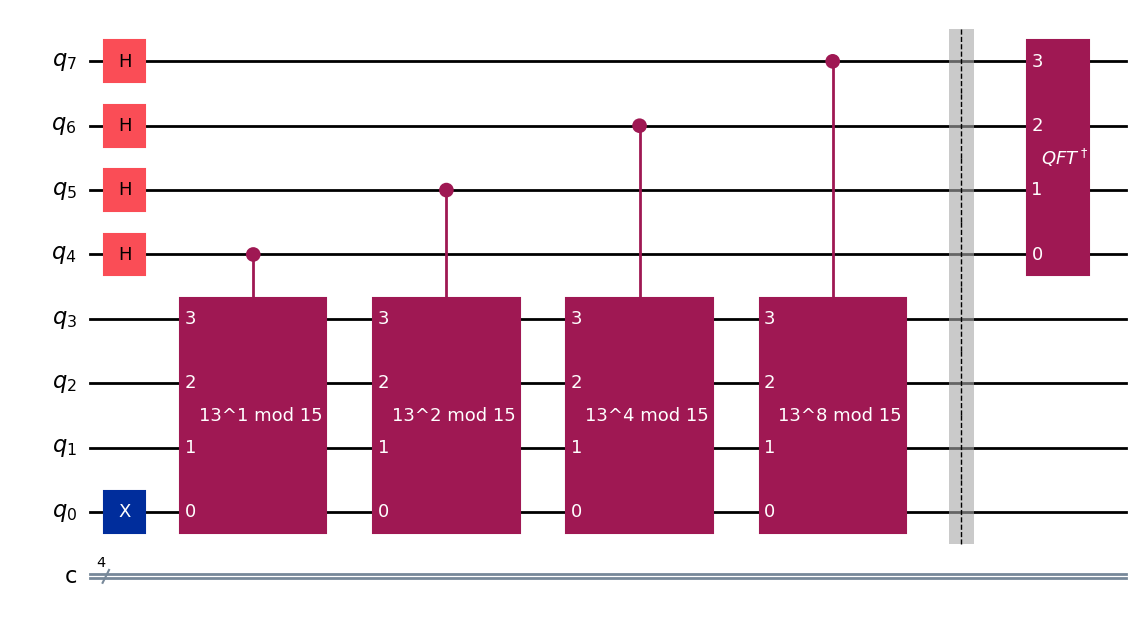

In [10]:
N = 15
num_control_qubits = 4
a = 13

def shor(num_control_qubits: int, a: int) -> QuantumCircuit:
    phi_num_qubits = 4
    total_qubits = phi_num_qubits + num_control_qubits
    qc = QuantumCircuit(total_qubits, num_control_qubits)
    # for i in range(phi_num_qubits):
    qc.x(0)
    for i in range(total_qubits-num_control_qubits, total_qubits):
        qc.h(i)
    # qc.append(c_amod15(a, N), [5, 1,2,3,4])
    for i in range(num_control_qubits):
        qc.append(c_amod15(a, np.pow(2,i)), [phi_num_qubits+i, 0,1,2,3])

    qc.barrier()

    qc.append(QFT_inverse(num_control_qubits), range(phi_num_qubits, phi_num_qubits+num_control_qubits))

    return qc

qc = shor(num_control_qubits, a)
qc.draw("mpl", reverse_bits=True)

---
Lets try to measure and see what we get:

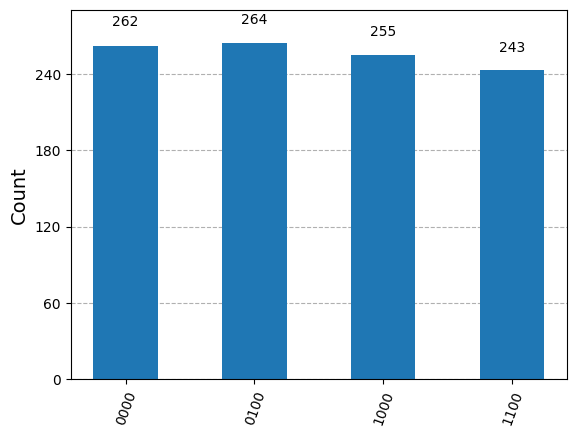

In [11]:
qc = shor(num_control_qubits, a)
qc.measure(range(4, 4+num_control_qubits), range(num_control_qubits))
t_qc = transpile(qc, backend)
counts = backend.run(t_qc).result().get_counts()
plot_histogram(counts)

Now we have several different measurement outcomes, one or more of which (hopefully) tell us about the period $r$. Let's start by computing the different phases these represent:

In [12]:
phases = []
for output in counts:
    state = int(output, 2)
    phase = state/(2**len(output))  # Find corresponding phase of eigenvalue as a float between 0 and 1
    phases.append(phase)

print(phases)

[0.0, 0.25, 0.5, 0.75]


It is a lot more useful for us to look at these phases as a fraction, so lets convert them using a simple python library:

In [13]:
fractions = []
for phase in phases:
    frac = Fraction(phase).limit_denominator(N) # We know the that the period r must be less than N
    print(frac)
    fractions.append(frac)

0
1/4
1/2
3/4


These phases will all be on the form $\frac{s}{r}$, where $s$ is an integer in the range $[0, r)$.
##### 5. You may notice that the period $r$ is not present in the denominator of all the values. Why does this happen, and to what extent is it an "issue"?

##### 6. We can now extract $r$ (or what we think $r$ likely is) based on the list of fractions. Implement a function *extract_r(fractions)* which finds the most likely candidate for $r$ based on the phase-fractions provided.

In [14]:
def extract_r(fractions: list[Fraction]) -> int:
    return max(fractions).denominator

r = extract_r(fractions)
print(r)

4


We now have the period $r$ of $a^x \bmod{15}$ for your choice of $a$. Let's now use this information to (hopefully) factorize 15.

Since we know $a^r \bmod{N} = 1$, we also know that $(a^r-1) \bmod{N} = 0$.

From here, we can do some basic middle school math magic to derive that:
$$(a^r-1) \bmod{N} = 0 \implies (a^\frac{r}{2}-1)(a^\frac{r}{2}+1) \bmod{N} = 0$$

(If $r$ was odd, we unfortunately would've been forced to started over with a different choice of $a$. Fortunately for us, we chose 15 such that you do not run into this issue for any valid choice of $a$).

From here we will blindly trust number theory, which tells us that the greatest-common-divisor between $a^\frac{r}{2} \pm 1$ and $N$ are both good candidates to be non-trivial factors of $N$.

Furthermore, this can be done using classical computers in $O(\log{n})$ time!

##### 6. Compute the Greatest Common Divisor between $N$ and $a^\frac{r}{2} \pm 1$. Does this provide us with an answer we were looking for? Try out some different values for $a$ and see how the result is affected.

In [15]:
type(r//2)
d1 = np.gcd(N, a ** ((r//2)) + 1)
d2 = np.gcd(N, a ** ((r//2))-1)
print(d1, d2)

5 3
